# GrabCut Segmentation for Brain images

In this example, we try to segment a 2d input images for time saving purposes.
Ref: https://www.sicara.fr/blog-technique/grabcut-for-automatic-image-segmentation-opencv-tutorial

In [206]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib as mpl    
import matplotlib.ticker as ticker
import numpy as np
import math
import cv2
from scipy.stats import norm
# for display
sub_size = 16
sup_size=20

In [208]:
def show_image(image, title=None):
    fig = plt.figure(figsize=(5,5))
    # plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title(title, fontsize=sup_size)
    plt.show()

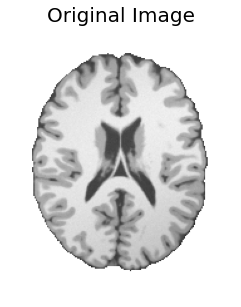

In [254]:
#%% Show original image
original_image = cv2.imread('../Data/brain_white_bg.png')
# original_image = cv2.imread('../Data/brain.png')
show_image(original_image, "Original Image")

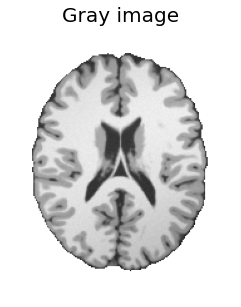

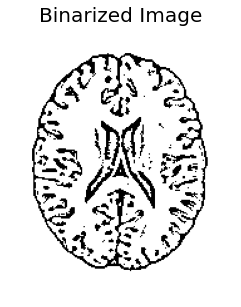

In [255]:
#%% Binarize input image
gray_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)
show_image(gray_image, "Gray image")

binarized_image = cv2.adaptiveThreshold(
    gray_image,
    maxValue=1,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY,
    blockSize=9,
    C=7,
)
show_image(binarized_image, "Binarized Image")

In [256]:
#%% Set GrabCut parameters
cv2.setRNGSeed(0)
number_of_iterations = 10

# Define boundary rectangle containing the foreground object
height, width, _ = original_image.shape
left_margin_proportion = 0.1
right_margin_proportion = 0.1
up_margin_proportion = 0.1
down_margin_proportion = 0.1

boundary_rectangle = (
    int(width * left_margin_proportion),
    int(height * up_margin_proportion),
    int(width * (1 - right_margin_proportion)),
    int(height * (1 - down_margin_proportion)),
)

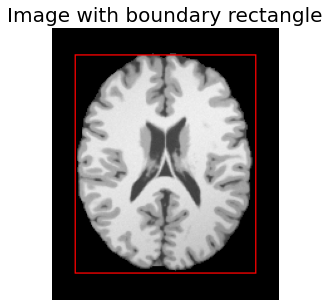

In [249]:
#%%
original_image_with_boundary_rectangle = cv2.rectangle(
    original_image.copy(),
    (int(width * left_margin_proportion), int(height * up_margin_proportion)),
    (
        int(width * (1 - right_margin_proportion)),
        int(height * (1 - down_margin_proportion)),
    ),
    (255, 0, 0),
    1,
)
show_image(original_image_with_boundary_rectangle, "Image with boundary rectangle")

In [250]:
def show_mask(image, title=None, nbins=3):
    fig = plt.figure(figsize=(5,5))
    if nbins==2:
        cmp = mpl.colors.ListedColormap(['k', 'w'])
    elif nbins==3:
        cmp = mpl.colors.ListedColormap(['k', 'b', 'gray', 'w'])
    img = plt.imshow(image, cmap=cmp)
    plt.axis('off')
    plt.title(title, fontsize=sup_size)

    fig.subplots_adjust(right=0.9) # set width of the left three subplot equal to 0.9 
    # set the size of colorbar
    l=0.92; b=0.12; w=0.015; h=1-2*b #left, bottom, width, hight
    # set the position of colorbar
    rect = [l,b,w,h]
    cbar_ax = fig.add_axes(rect)
    cb1 = fig.colorbar(img, cax=cbar_ax)
    # # set the scale of colobar
    tick_locator = ticker.MaxNLocator(nbins=nbins)
    cb1.locator = tick_locator
    if nbins==2:
        cb1.set_ticks([0,1])
    elif nbins==3:
        cb1.set_ticks([0,1,2,3])
    cb1.update_ticks()

    plt.show()

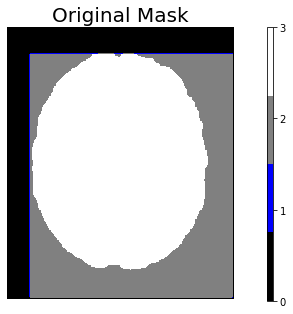

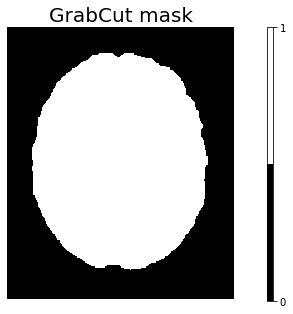

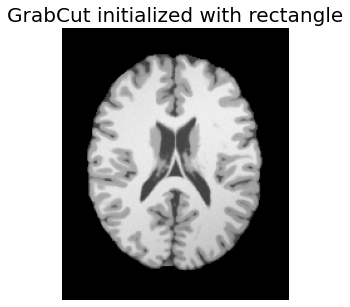

In [251]:
#%% GrabCut initialized only with a rectangle

# Initialize mask image
mask = np.zeros((height, width), np.uint8)

# Arrays used by the algorithm internally
background_model = np.zeros((1, 65), np.float64)
foreground_model = np.zeros((1, 65), np.float64)

cv2.grabCut(
    img=original_image,
    mask=mask,
    rect=boundary_rectangle,
    bgdModel=background_model,
    fgdModel=foreground_model,
    iterCount=number_of_iterations,
    mode=cv2.GC_INIT_WITH_RECT,
)

show_mask(mask, "Original Mask", nbins=3)

grabcut_mask = np.where((mask == cv2.GC_PR_BGD) | (mask == cv2.GC_BGD), 0, 1).astype("uint8")

show_mask(grabcut_mask, "GrabCut mask", nbins=2)

segmented_image = original_image.copy() * grabcut_mask[:, :, np.newaxis]

show_image(segmented_image, "GrabCut initialized with rectangle")


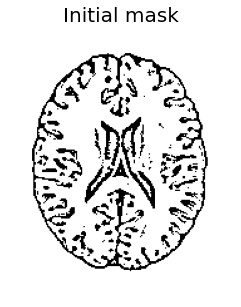

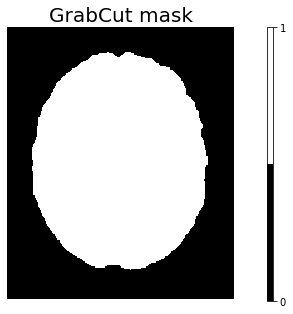

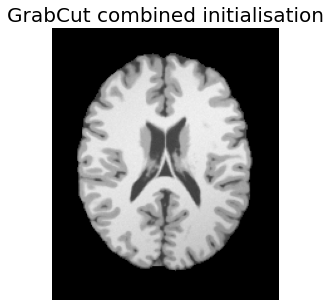

In [258]:
#%% GrabCut with initial mask

# Initialize the mask with known information
initial_mask = binarized_image.copy()
show_image(255 * initial_mask, "Initial mask")

mask = np.zeros((height, width), np.uint8)
mask[:] = cv2.GC_PR_BGD
mask[initial_mask == 0] = cv2.GC_FGD

# Arrays used by the algorithm internally
background_model = np.zeros((1, 65), np.float64)
foreground_model = np.zeros((1, 65), np.float64)

cv2.grabCut(
    original_image,
    mask,
    boundary_rectangle,
    background_model,
    foreground_model,
    number_of_iterations,
    cv2.GC_INIT_WITH_MASK,
)
grabcut_mask = np.where((mask == cv2.GC_PR_BGD) | (mask == cv2.GC_BGD), 0, 1).astype("uint8")

show_mask(grabcut_mask, "GrabCut mask", nbins=2)

grabcut_image = original_image.copy() * grabcut_mask[:, :, np.newaxis]

show_image(grabcut_image, "GrabCut combined initialisation")